**Table of contents**<a id='toc0_'></a>    
- 1. [Problem 1: Optimal taxation with government consumption](#toc1_)    
- 2. [Problem 2: Labor adjustment costs](#toc2_)    
- 3. [Problem 3: Global optimizer with refined multi-start](#toc3_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

**Load packages:**

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import sympy as sm
import math

from scipy import linalg
from scipy import optimize  

import matplotlib.pyplot as plt
plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

from scipy import optimize

from IPython.display import display

from types import SimpleNamespace  

## 1. <a id='toc1_'></a>[Problem 1: Optimal taxation with government consumption](#toc0_)


Consider a worker choosing hours of labor, $L\in[0,24]$, to maximize utility: 

$$
\begin{align*}
V(w,\tau,G)&=\max_{L\in[0,24]}\ln\left(C^{\alpha}G^{1-\alpha}\right)-\nu\frac{L^{2}}{2}\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}
$$

where 

* $C$ is *private* consumption with weight $\alpha\in(0,1)$.
* $\kappa > 0$ is the *free private* consumption component.
* $C = (1-\tau)wL$ is the *costly private* consumption component.
* $w > 0 $ is the real wage.
* $\tau \in (0,1)$ is the labor-income tax rate.
* $G > 0 $ is *government* consumption with weight $1-\alpha$.
* $\nu > 0$ is the disutility of labor scaling factor


The baseline parameters are:

$$
\begin{align*}
\alpha &= 0.5\\
\kappa &= 1.0\\
\nu &= \frac{1}{2\cdot16^2} \\
w &= 1.0 \\ 
\tau &= 0.30 \\
\end{align*}
$$

**Question 1:** Verify that the optimal labor supply choice is $L^{\star}(\tilde{w}) =\frac{-\kappa+\sqrt{\kappa^{2}+4\frac{\alpha}{\nu}\tilde{w}^2}}{2\tilde{w}}$, where $\tilde{w} = (1-\tau)w$, for $G\in\left\{1.0 , 2.0\right\}$.

**Answer** 

We solve the model using symbolic math. First we define the central parameters, choice variables, functions and equations.

**Model parameters**

In [2]:
# Parameters (symbolic)
alpha       = sm.symbols('alpha')   # share parameter
v           = sm.symbols('v')       # ??? disutility of labor
kappa       = sm.symbols('kappa')   # consumer cash on hand
w           = sm.symbols('w')       # real wage rate

# Variables (symbolic)
tau         = sm.symbols('tau')     # tax rate
G           = sm.symbols('G')       # government spending
L           = sm.symbols('L')       # labor supply
C           = sm.symbols('C')       # consumption

# Function names / outputs (symbolic)
wtilde      = sm.symbols('wtilde')  # after tax real wage rate
U           = sm.symbols('U')       # utility  

# Baseline parameters (values for later use)
alpha_val   = 0.5
v_val       = 1/(2*16**2)
kappa_val   = 1.0
w_val       = 1.0            
tau_val     = 0.3
wtilde_val  = (1-tau_val)*w_val     # = 0.70

# Parameters to use in plots
parameter_values = [alpha_val, v_val, kappa_val]

**Functions and equations**

In [3]:
# Utility function
utility           = sm.log(C**alpha * G**(1-alpha)) - v * L**2 / 2
display(utility)

-L**2*v/2 + log(C**alpha*G**(1 - alpha))

In [4]:
# Budget constraint
budget_constraint = sm.Eq(C,kappa + (1- tau)*w*L)
display(budget_constraint)

Eq(C, L*w*(1 - tau) + kappa)

In [5]:
# After tax real wage rate
after_tax_wage    = sm.Eq(wtilde, (1-tau)*w)
display(after_tax_wage)

Eq(wtilde, w*(1 - tau))

**Solve for optimal labor supply**

To verify formula for the optimal labor supply, we then find the first order condition for optimal labor supply $L^*(\tilde{w})$ by:

1. Insert the value for $\tilde{w}$ in the budget constaint
2. Insert the expression for $C$ in the utility function
3. Find the partial derivative of $U$ wrt. $L$ and set it equal to zero
4. Solve the expression for $L$. Noting that there are two solutions, we pick the one where $L$ is positive

In [6]:
# 1. Budget constraint with w(1-tau) = wtilde
budget_constraint1 = budget_constraint.subs((1-tau)*w, wtilde)
display(budget_constraint1)

Eq(C, L*wtilde + kappa)

In [7]:
# 2. Utility with budget constraint subtituted
budget_constraint1 = sm.solve(budget_constraint1,C)
utility1 = utility.subs(C,budget_constraint1[0])
display(utility1)

-L**2*v/2 + log(G**(1 - alpha)*(L*wtilde + kappa)**alpha)

In [8]:
# 3. Partial derivative of utility wrt. L
foc = sm.diff(utility1,L)
foc = sm.simplify(foc)
foc = sm.Eq(foc,0)
display(foc)

Eq((-L*v*(L*wtilde + kappa) + alpha*wtilde)/(L*wtilde + kappa), 0)

In [9]:
# 2. Solve for optimal L
sol = sm.solve(foc, L)

sol1 = sol[1] # pick second solution (where L is positive)

Optimal_L = sm.Eq(L,sol1)
display(Optimal_L)

Eq(L, (-kappa*v + sqrt(v*(4*alpha*wtilde**2 + kappa**2*v)))/(2*v*wtilde))

We note optimal labor supply $L^*(\tilde{w})$ is independent of government spending. To confirm the result, we plot the utility function as a function of $L$ for $G \in \{1.0,2.0\}$.

In [10]:
# Analytic expression for utility given optimal level of labor
utility2 = utility1.subs(Optimal_L.lhs,Optimal_L.rhs)
display(utility2)

log(G**(1 - alpha)*(kappa + (-kappa*v + sqrt(v*(4*alpha*wtilde**2 + kappa**2*v)))/(2*v))**alpha) - (-kappa*v + sqrt(v*(4*alpha*wtilde**2 + kappa**2*v)))**2/(8*v*wtilde**2)

In [11]:
# lambdify function expressions which allows these expressions to be evaulated numerically (some for later use)
Lambda_sol1         = sm.lambdify(args=(alpha,v,kappa,wtilde),     expr = sol1)
Lambda_utility1     = sm.lambdify(args=(alpha,v,kappa,wtilde,G,L), expr = utility1)
Lambda_utility2     = sm.lambdify(args=(alpha,v,kappa,wtilde,G),   expr = utility2)

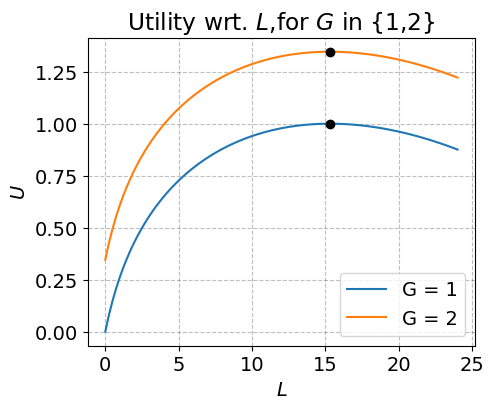

In [12]:
# Utility as a function of labor supply for different levels of G
L_vec = np.linspace(0,24,100)

# Optimal value of labor supply
values_optimal_L = Lambda_sol1(*parameter_values, wtilde=wtilde_val)

# Plot
fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(1,1,1)

for G_val in [1,2]:
    utility_vec       = Lambda_utility1(*parameter_values, wtilde=wtilde_val, G = G_val, L = L_vec)

    utility_optimal_L = Lambda_utility2(*parameter_values, wtilde=wtilde_val,G = G_val)

    # Graph
    ax.plot(L_vec,utility_vec, label = 'G = ' + str(G_val))

    # Plot the optimal value of labor
    ax.plot(values_optimal_L,utility_optimal_L, 'o', color = 'black')

ax.legend(loc='lower right')
ax.set_xlabel('$L$')
ax.set_ylabel('$U$')
ax.set_title('Utility wrt. $L$,for $G$ in {1,2}')

plt.show()

**Question 2:** Illustrate how $L^{\star}(\tilde{w})$ depends on $w$.

**Answer**

We show below that optimal labor supply i.e., $L^{\star}(\tilde{w})=L^{\star}((1-\tau)w)$ is increasing in $w$. For $w=1$ after-tax real wage is 0.70 meaning optimal supply given the parameters is $L^*=15.30$.

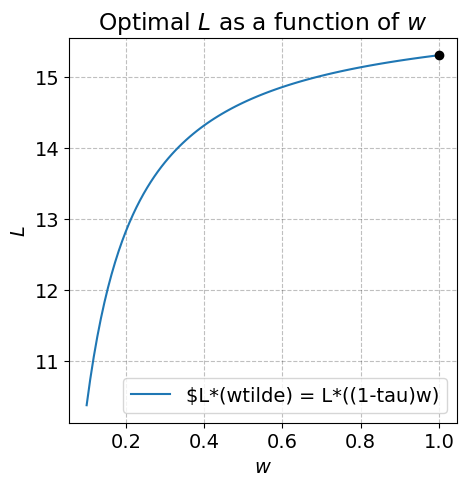

In [13]:
# Vector of possible real wage values
w_vec    = np.linspace(0.1,1,100)

# Vector of after tax real wage rate
wtilde_vec = (1 - tau_val) * w_vec 

# A vector of optimal L is made (given after tax real wage rate)
Optimal_L_vec = Lambda_sol1(*parameter_values, wtilde=wtilde_vec)

# Plot results (using w instead of wtilde)
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1)
ax.plot(w_vec,Optimal_L_vec, label = '$L*(wtilde) = L*((1-tau)w)')
# add black dot at optimal L
ax.plot(1.0,values_optimal_L, 'o', color = 'black')
ax.set_title('Optimal $L$ as a function of $w$')
ax.set_xlabel('$w$')
ax.set_ylabel('$L$')
ax.legend(loc='lower right')

plt.show()


We now consider a government, who chooses $\tau$ and spend all of the taxes on government consumption so:

$$
G = \tau w L^{\star}((1-\tau)w)
$$

**Question 3:** Plot the implied $L$, $G$ and worker utility for a grid of $\tau$-values.


**Answer**

We first define all the equations with relevant substitutions.

**Government spending**

In [14]:
# Government budget is identified
govbudget = sm.Eq(G,tau*w*L)
display(govbudget)

Eq(G, L*tau*w)

In [15]:
# Optimal labor is substituted into the government budget
govbudget1 = govbudget.subs(L,Optimal_L.rhs)
display(govbudget1)

Eq(G, tau*w*(-kappa*v + sqrt(v*(4*alpha*wtilde**2 + kappa**2*v)))/(2*v*wtilde))

In [16]:
# The value of wtilde is substituted into the government budget
govbudget2 = govbudget1.subs(wtilde,(1-tau)*w)
display(govbudget2)

Eq(G, tau*(-kappa*v + sqrt(v*(4*alpha*w**2*(1 - tau)**2 + kappa**2*v)))/(2*v*(1 - tau)))

**Labor supply**

In [17]:
# The value of wtilde in government budget is substituted with (1-tau)*w
govbudget2 = govbudget2.subs(wtilde,(1-tau)*w)
display(govbudget2)

Eq(G, tau*(-kappa*v + sqrt(v*(4*alpha*w**2*(1 - tau)**2 + kappa**2*v)))/(2*v*(1 - tau)))

In [18]:
# Government budget is set equal to function value of government budget
Govbudget3 = govbudget2.subs(govbudget.lhs,govbudget.rhs)
display(Govbudget3)

Eq(L*tau*w, tau*(-kappa*v + sqrt(v*(4*alpha*w**2*(1 - tau)**2 + kappa**2*v)))/(2*v*(1 - tau)))

In [19]:
# Implied L is identified
implied_L = sm.solve(Govbudget3,L)
implied_L1= sm.Eq(L,implied_L[0])
display(implied_L1)

Eq(L, (kappa*v - sqrt(v*(4*alpha*w**2*(tau - 1)**2 + kappa**2*v)))/(2*v*w*(tau - 1)))

**Worker utility**

In [20]:
# Utility with budget constraint
display(utility1)

-L**2*v/2 + log(G**(1 - alpha)*(L*wtilde + kappa)**alpha)

In [21]:
# Substitute utility with budget constraint into government budget
utility_sub1 = utility1.subs(govbudget2.lhs,govbudget2.rhs)
display(utility_sub1)

-L**2*v/2 + log((tau*(-kappa*v + sqrt(v*(4*alpha*w**2*(1 - tau)**2 + kappa**2*v)))/(2*v*(1 - tau)))**(1 - alpha)*(L*wtilde + kappa)**alpha)

In [22]:
# The expression for optimal labor is substituted into the function
utility_sub2 = utility_sub1.subs(implied_L1.lhs,implied_L1.rhs)
display(utility_sub2)

log((tau*(-kappa*v + sqrt(v*(4*alpha*w**2*(1 - tau)**2 + kappa**2*v)))/(2*v*(1 - tau)))**(1 - alpha)*(kappa + wtilde*(kappa*v - sqrt(v*(4*alpha*w**2*(tau - 1)**2 + kappa**2*v)))/(2*v*w*(tau - 1)))**alpha) - (kappa*v - sqrt(v*(4*alpha*w**2*(tau - 1)**2 + kappa**2*v)))**2/(8*v*w**2*(tau - 1)**2)

In [23]:
# wtilde is substitued with (1-tau)*w
utility_sub3 = utility_sub2.subs(wtilde,(1-tau)*w)
display(utility_sub3)

log((tau*(-kappa*v + sqrt(v*(4*alpha*w**2*(1 - tau)**2 + kappa**2*v)))/(2*v*(1 - tau)))**(1 - alpha)*(kappa + (1 - tau)*(kappa*v - sqrt(v*(4*alpha*w**2*(tau - 1)**2 + kappa**2*v)))/(2*v*(tau - 1)))**alpha) - (kappa*v - sqrt(v*(4*alpha*w**2*(tau - 1)**2 + kappa**2*v)))**2/(8*v*w**2*(tau - 1)**2)

**Plot government spending, labor supply and utility wrt. $\tau$**

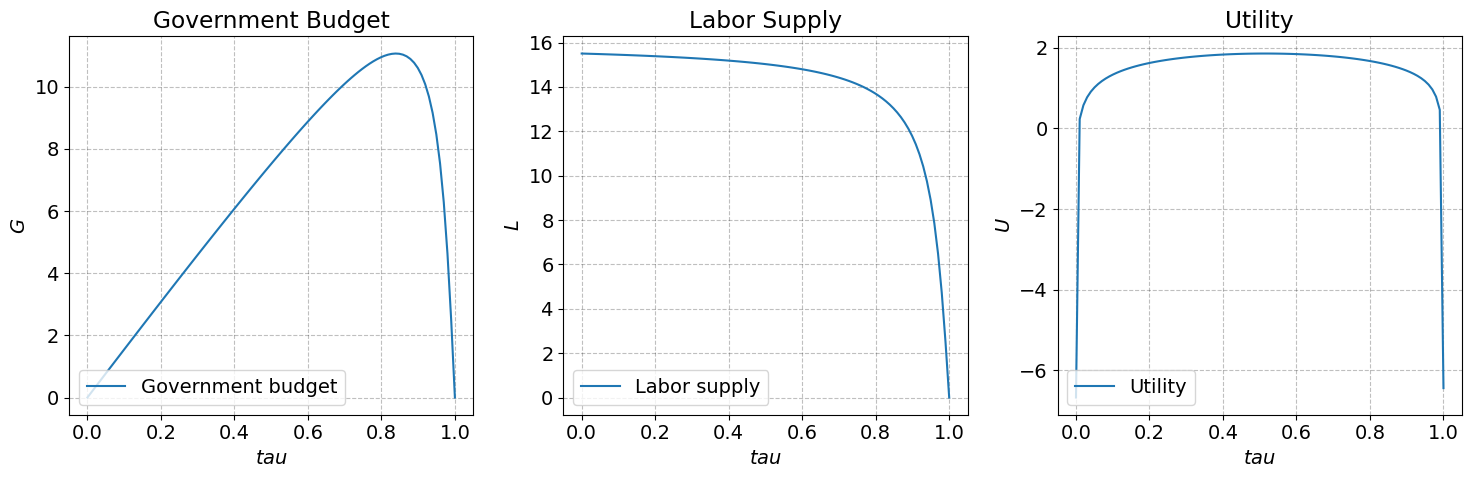

In [24]:
# Lambdafy all three expressions

# Goverment budget
Lambda_govbudget2 = sm.lambdify(args=(alpha, v, kappa, w, tau), expr=govbudget2.rhs)

# Labor supply
Lambda_implied_L = sm.lambdify(args=(alpha, v, kappa, w, tau), expr=implied_L[0])

# Utility
Lambda_utility_sub3 = sm.lambdify(args=(alpha, v, kappa, w, tau), expr=utility_sub3)

# Vector of possible tax rates
tau_vec = np.linspace(1e-8,1-1e-8,100)

# Vectors to plot
gov_vec     = Lambda_govbudget2(*parameter_values,   w=w_val, tau=tau_vec)
l_vec       = Lambda_implied_L(*parameter_values,    w=w_val, tau=tau_vec)
utility_vec = Lambda_utility_sub3(*parameter_values, w=w_val, tau=tau_vec)

# Vector of possible tax rates
tau_vec = np.linspace(1e-8, 1-1e-8, 100)

# Compute vectors
gov_vec = Lambda_govbudget2(*parameter_values, w=w_val, tau=tau_vec)
l_vec = Lambda_implied_L(*parameter_values, w=w_val, tau=tau_vec)
utility_vec = Lambda_utility_sub3(*parameter_values, w=w_val, tau=tau_vec)

# Plotting
fig = plt.figure(figsize=(15, 5))

# Government budget
ax1 = fig.add_subplot(1, 3, 1)
ax1.plot(tau_vec, gov_vec, label='Government budget')
ax1.set_xlabel('$tau$')
ax1.set_ylabel('$G$')
ax1.legend(loc='lower left')
ax1.set_title('Government Budget')

# Labor supply
ax2 = fig.add_subplot(1, 3, 2)
ax2.plot(tau_vec, l_vec, label='Labor supply')
ax2.set_xlabel('$tau$')
ax2.set_ylabel('$L$')
ax2.legend(loc='lower left')
ax2.set_title('Labor Supply')

# Utility
ax3 = fig.add_subplot(1, 3, 3)
ax3.plot(tau_vec, utility_vec, label='Utility')
ax3.set_xlabel('$tau$')
ax3.set_ylabel('$U$')
ax3.legend(loc='lower left')
ax3.set_title('Utility')

# Adjust spacing
plt.tight_layout()

# Show the plot
plt.show()

From the plot it is evident that government consumption and labor-income tax are positively correlated but that government consumption cannot increase spending by raising taxes higher than above about 0.85. It's a classic laffer-curve. Higher tax levels decreases labor supply,  especially for tax levels above 0.80. But as workers value government consumption there is a utility maximizing tax rate around 0.50. 

**Question 4:** Find the socially optimal tax rate $\tau^{\star}\in(0,1)$ maximizing worker utility. Illustrate your result.

**Answer**

We find below that the optimal tax rate is $\tau = 0.51$.

Optimal tax rate: 0.515
Utility at optimal tax rate: 1.859


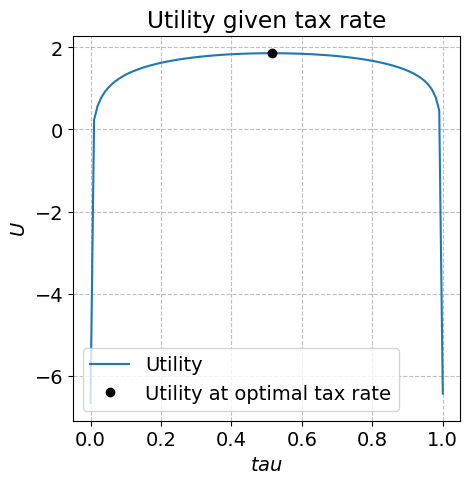

In [25]:
# Define objective function
obj = lambda tau : -Lambda_utility_sub3(kappa=kappa_val,v=v_val,alpha=alpha_val,w=w_val,tau=tau)

# Define bounds 
bounds=[(1e-8,1-1e-8)]

# Define optimizer
opt = optimize.minimize(obj, 0.5, method='Nelder-Mead', bounds=bounds)
opt_tau = opt.x[0]

print(f'Optimal tax rate: {opt_tau:.3f}')
print(f'Utility at optimal tax rate: {-opt.fun:.3f}')

# Plot the result
fig = plt.figure(figsize=(5,5))

ax = fig.add_subplot(1,1,1)

ax.plot(tau_vec,utility_vec, label='Utility')
ax.plot(opt_tau,-opt.fun,'o', color='black', label='Utility at optimal tax rate')
ax.set_xlabel('$tau$')
ax.set_ylabel('$U$')
ax.legend(loc='lower left')
ax.set_title('Utility given tax rate')

plt.show()

A more general preference formulation for the worker is:

$$
\begin{align*}
\mathcal{V}(w,\tau,G)&=\max_{L\in[0,24]}\frac{\left[ \left( \alpha C^{\frac{\sigma-1}{\sigma}}+(1-\alpha) G^{\frac{\sigma-1}{\sigma}} \right)^{\frac{\sigma}{\sigma-1} }\right]^{1-\rho}-1}{1-\rho}- \nu\frac{L^{1+\varepsilon}}{1+\varepsilon},\,\,\,\varepsilon,\rho,\sigma>0,\,\,\,\rho,\sigma\neq1\\&\text{s.t.}\\&C=\kappa+(1-\tau)wL
\end{align*}    
$$

Optimal labor supply is now $L^{\star}(\tilde{w},G)$.

Questions 5 and 6 must be answered with the general formulation, and for 2 different set of parameters:

- Set 1:  $\sigma = 1.001$, $\rho = 1.001$ and $\varepsilon = 1.0$.
- Set 2:  $\sigma = 1.5$, $\rho = 1.5$ and $\varepsilon = 1.0 $.

**Question 5:** Find the $G$ that solves $G = \tau w L^{\star}((1-\tau)w,G)$ using the $\tau$ found in question 4.

*Hint: First write code that solves the worker problem for given values of $G$ and $\tau$. Then find the correct G based on this.*

**Answer**

The new model cannot be solved analytically. Thus, we have defined **OptimalTaxationModelClass** with the more general preference formulation of the optimal taxation model in exam2023.pyfile. This is the best class ever. You should totally head over to the pyfile and check it out!

In [26]:
# Import Class
from Exam2023 import OptimalTaxationModelClass

# Create instance
model = OptimalTaxationModelClass()

# Illustrate effect of solving model (flag is set to True when model is solved)
print(model.flag)
tau_star = model.solve_tau()
print(model.flag)

namespace(found_sol_tau=False, found_sol_G=False, found_sol_L=False, found_sol_C=False)
namespace(found_sol_tau=True, found_sol_G=True, found_sol_L=True, found_sol_C=True)


 We try using the previous optimal tax rate $(0.51)$ from the analytic model as a guess at the optimal tax rate.
 
 The model is first solved for $L*$ and G at $\sigma = 1.0001$ and $\rho = 1.0001$. The government spending that balances the budget is 7.51 given that the workers optimize their labor supply (using the new model specification).
 
 In comparison, when the model is solved for $\sigma = 1.5$ and $\rho = 1.5$ clearing government expenditure decreases to 4.86.   

In [43]:
# Create an instance of the OptimalTaxationModelClass
model = OptimalTaxationModelClass()

# Guess that the optimal tax rate is the same as in the analytic solution
tau_star_guess = 0.51455078125

# Solve for the optimal government spending given the guessed tax rate
G_star = model.solve_G(tau_star_guess)

# Print the flag indicating if a solution was found
print(f'Solved model? {model.flag}\n')

# Create a vector of tax rates to evaluate
tau_vec = np.linspace(model.par.eps, 1, 100)

# Initialize vectors for optimal government spending and labor supply
G_star_vec_1 = np.empty(100)
L_star_vec_1 = np.empty(100)

# Loop through the tax rates and solve for optimal G and L
for i in range(np.size(tau_vec)):
    G_star_vec_1[i] = model.solve_G(tau_vec[i])
    L_star_vec_1[i] = model.solve_L(tau_vec[i], G_star_vec_1[i])

    # Check if a solution for G was not found
    if model.flag.found_sol_G == False:
        break

# Print the optimal guessed tax rate and government spending
print(f'Optimal guessed tax rate is: {tau_star_guess:.2f}')
print(f'Optimal government spending is: {G_star:.2f}')

Solved model? namespace(found_sol_tau=False, found_sol_G=True, found_sol_L=True, found_sol_C=True)

Optimal guessed tax rate is: 0.51
Optimal government spending is: 7.71


In [42]:
# Create an instance of the OptimalTaxationModelClass
model = OptimalTaxationModelClass()

# Set model parameters
model.par.sigma = 1.5
model.par.rho = 1.5

# Guess that the optimal tax rate is the same as in the analytic solution
tau_star_guess = 0.51455078125

# Solve for the optimal government spending given the guessed tax rate
G_star = model.solve_G(tau_star_guess)

# Print the flag indicating if a solution was found
print(f'Solved model? {model.flag}\n')

# Create a vector of tax rates to evaluate
tau_vec = np.linspace(model.par.eps, 1, 100)

# Initialize vectors for optimal government spending and labor supply
G_star_vec_2 = np.empty(100)
L_star_vec_2 = np.empty(100)

# Loop through the tax rates and solve for optimal G and L
for i in range(np.size(tau_vec)):
    G_star_vec_2[i] = model.solve_G(tau_vec[i])
    L_star_vec_2[i] = model.solve_L(tau_vec[i], G_star_vec_2[i])

    # Check if a solution for G was not found
    if model.flag.found_sol_G == False:
        break

# Print the optimal guessed tax rate and government spending
print(f'Optimal guessed tax rate is: {tau_star_guess:.2f}')
print(f'Optimal government spending is: {G_star:.2f}')

Solved model? namespace(found_sol_tau=False, found_sol_G=True, found_sol_L=True, found_sol_C=True)

Optimal guessed tax rate is: 0.51
Optimal government spending is: 4.98


**Question 6:** Find the socially optimal tax rate, $\tau^{\star}$, maximizing worker utility, while keeping $G = \tau w L^{\star}((1-\tau)w,G)$.

**Answer**

We now solve the model for the utility maximizing tax rate taking into account the actual CES utility function (see below).

For $\sigma = 1.0001$ and $\rho = 1.0001$ the optimal tax rate is 0.51 which is very close to the analytical solution from the simple model

For $\sigma = 1.5$ and $\rho = 1.5$ the optimal tax rate is lower at 0.46. This is because workers are more willing to substitute governemnt spending for private consumption, so $G$ is less valuable.

Finally we plot optimal labor supply and government spending for different values of $\tau$ as well as indication the social planner solution.

In [41]:
# Param 1
model = OptimalTaxationModelClass()

# Solve model step by step and save results
tau_star = model.solve_tau()
G_star   = model.solve_G(tau_star)
L_star   = model.solve_L(tau_star,G_star)
C_star   = model.solve_C(tau_star,L_star)

# Print model flag
print(f'Solved model? {model.flag}\n')

# Print results
print(f'Optimal tax rate is: {tau_star:.2f}')
print(f'Optimal government spending is: {G_star:.2f}')
print(f'Optimal labor supply is: {L_star:.2f}')
print(f'Optimal consumption is: {C_star:.2f}')

# Store results for plotting
tau_star1 = tau_star
G_star1   = G_star
L_star1   = L_star

Solved model? namespace(found_sol_tau=True, found_sol_G=True, found_sol_L=True, found_sol_C=True)

Optimal tax rate is: 0.51
Optimal government spending is: 7.71
Optimal labor supply is: 14.99
Optimal consumption is: 8.28


In [39]:
# Param 2
model = OptimalTaxationModelClass()

# Update parameters
model.par.sigma = 1.5
model.par.rho   = 1.5

# Solve model step by step and save results
tau_star = model.solve_tau()
G_star   = model.solve_G(tau_star)
L_star   = model.solve_L(tau_star,G_star)
C_star   = model.solve_C(tau_star,L_star)

# Print model flag
# Param 1
model = OptimalTaxationModelClass()

# Solve model step by step and save results
tau_star = model.solve_tau()
G_star   = model.solve_G(tau_star)
L_star   = model.solve_L(tau_star,G_star)
C_star   = model.solve_C(tau_star,L_star)

# Print model flag
print(f'Solved model? {model.flag}\n')

# Print results
print(f'Optimal tax rate is: {tau_star:.2f}')
print(f'Optimal government spending is: {G_star:.2f}')
print(f'Optimal labor supply is: {L_star:.2f}')
print(f'Optimal consumption is: {C_star:.2f}')

# Store results for plotting
tau_star1 = tau_star
G_star1   = G_star
L_star1   = L_star

# Print results
print(f'Optimal tax rate is: {tau_star:.2f}')
print(f'Optimal government spending is: {G_star:.2f}')
print(f'Optimal labor supply is: {L_star:.2f}')
print(f'Optimal consumption is: {C_star:.2f}')

# Store results for plotting
tau_star1 = tau_star
G_star1   = G_star
L_star1   = L_star

namespace(found_sol_tau=True, found_sol_G=True, found_sol_L=True, found_sol_C=True)

Optimal tax rate is: 0.46
Optimal government spending is: 4.57
Optimal labor supply is: 9.89
Optimal consumption is: 6.32


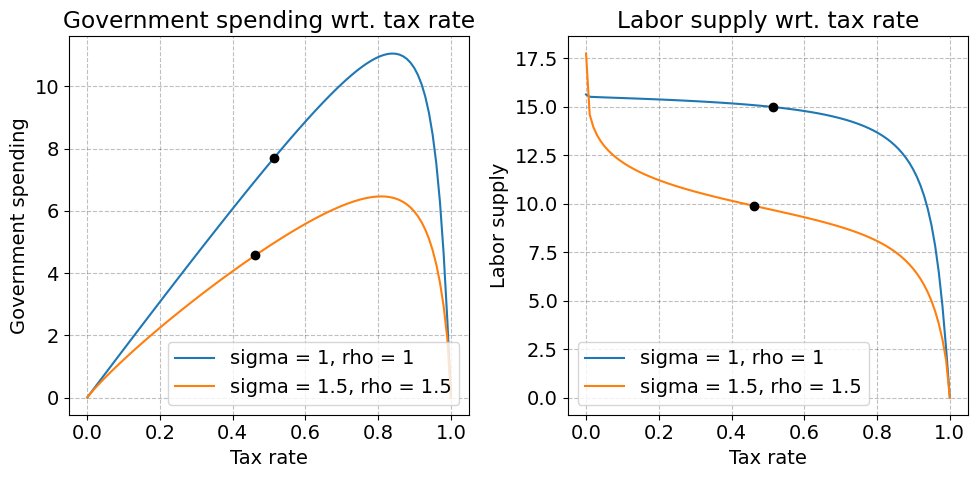

In [38]:
# Plot the two solutions
fig = plt.figure(figsize=(10,5))

# Government spending
ax1 = fig.add_subplot(1,2,1)
ax1.set_title('Government spending wrt. tax rate')
ax1.set_xlabel('Tax rate')
ax1.set_ylabel('Government spending')
ax1.plot(tau_vec,G_star_vec_1, label = 'sigma = 1, rho = 1')
ax1.plot(tau_vec,G_star_vec_2, label = 'sigma = 1.5, rho = 1.5')
ax1.plot(tau_star1,G_star1,'o', color = 'black')
ax1.plot(tau_star2,G_star2,'o', color = 'black')

ax1.legend()

# Labor supply
ax2 = fig.add_subplot(1,2,2)
ax2.set_title('Labor supply wrt. tax rate')
ax2.set_xlabel('Tax rate')
ax2.set_ylabel('Labor supply')
ax2.plot(tau_vec,L_star_vec_1, label = 'sigma = 1, rho = 1')
ax2.plot(tau_vec,L_star_vec_2, label = 'sigma = 1.5, rho = 1.5')
ax2.plot(tau_star1,L_star1,'o', color = 'black')
ax2.plot(tau_star2,L_star2,'o', color = 'black')

ax2.legend()

plt.tight_layout()

plt.show()

## 2. <a id='toc2_'></a>[Problem 2: Labor adjustment costs](#toc0_)

You own a hair salon. You employ hairdressers, $\ell_t$, to produce haircuts, $y_t = \ell_t$.

The wage for each haridresser is $w$.

The demand for haircuts implies that the price of haircuts you can charge is $p_t = \kappa_t y_t^{-\eta}$, where $\kappa_t$ is a demand-shock and $\eta \in (0,1)$ measures the elasticity of demand.

Profits are:

$$
\Pi_t = p_t y_t - w \ell_t = \kappa_t \ell_t^{1-\eta} - w \ell_t
$$

Baseline parameters are:
- $\eta = 0.5$
- $w = 1.0$

**Question 1:** Verify numerically that $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ maximises profits, for $\kappa\in\left\{1.0 , 2.0\right\}$.

In [32]:
from scipy import optimize
from scipy import interpolate
import sympy as sm

import numpy as np
from types import SimpleNamespace

from copy import deepcopy
import time

from matplotlib.ticker import MaxNLocator

import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

plt.rcParams.update({"axes.grid":True,"grid.color":"black","grid.alpha":"0.25","grid.linestyle":"--"})
plt.rcParams.update({'font.size': 14})

# Note: Numerically. We have to use a grid of l_t for kappa equal to 1 or 2 and see that profit is maximized for that l_t.
# solve using solver and graphical solution.

#Parameters
eta=0.5
w=1
kappa=1

kappa_vec = [1,2]

#Profit function
def calc_profit(l,kappa):
    p =  kappa*l**(-eta)
    profit =  p*l-w*l
    return profit 

for kappa in kappa_vec:
    l_guess=0.5
    obj = lambda l: -calc_profit(l[0],kappa)
    res = optimize.minimize(obj,l_guess,method='Nelder-Mead') 
    opt_l = res.x
    print(f'Numerical solution is {opt_l} for kappa={kappa}')
    l=(((1-eta)*kappa)/w)**(1/eta)
    print(f'Analytical solution is {[l]} for kappa={kappa}')
    print(f'Profit is {calc_profit(l,kappa)} for kappa={kappa}')

Numerical solution is [0.25] for kappa=1
Analytical solution is [0.25] for kappa=1
Profit is 0.25 for kappa=1
Numerical solution is [1.] for kappa=2
Analytical solution is [1.0] for kappa=2
Profit is 1.0 for kappa=2


We now consider a *dynamic* version of the model.

* The demand-shock is a so-called AR(1) in logs, 

$$
\log \kappa_{t} = \rho \log \kappa_{t-1} + \epsilon_{t},\,\,\, \epsilon_{t+1} \sim \mathcal{N}(-0.5\sigma_{\epsilon}^2,\sigma_{\epsilon})
$$

* Any hiring or firing implies a fixed adjustment cost, $\iota > 0 $.
* Future profits are discounted with a monthly factor of $R \in (0,1)$.

The initial demand shock is $\kappa_{-1} = 1$ and the planning horizon is 10 years, i.e. 120 months so $t \in \{0,1,2,\dots,119\}$. Initially you don't have any employees, $\ell_{-1}=0$


The *ex post* value of the salon is *conditional* on the shock series is:

$$
h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119}) = \left[\sum_{t=0}^{119}R^{-t}\left[\kappa_{t}\ell_{t}^{1-\eta}-w\ell_{t}-\boldsymbol{1}_{\ell_{t}\neq\ell_{t-1}}\iota\right]\right]
$$

The *ex ante* expected value of the salon can be approximated by

$$
H = \mathbb{E}[h(\epsilon_0,\epsilon_1,\dots,\epsilon_{119})] \approx \frac{1}{K}\sum_{k=0}^{K} h(\epsilon_0^k,\epsilon_1^k,\dots,\epsilon_{119}^k)
$$

where each $k\in\{0,1,\dots,K-1\}$ is a random shock series. Maximizing profitability means maximizing $H$.


Baseline parameters are: 

- $\rho = 0.90$
- $\iota = 0.01$
- $\sigma_{\epsilon} = 0.10$
- $R = \left(1+0.01\right)^{1/12}$

**Question 2:** Calculate $H$ if the policy  $\ell_{t}=\left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}}$ from question 1 is followed. Choose $K$ so the approximation is good enough to not affect your results substantially.

In [33]:
# PLug delta ind og find samlet ex post nytte
def calc_opt_l(eta,kappa,w):
   return (((1-eta)*kappa)/w)**(1/eta)

def calc_profit_adj(l,kappa,iota):
    profit = np.where(l!=0, kappa*l**(-eta)*l -w*l-iota, 0)
    return profit 

def simulate(K=10000, Delta=0.05, follow_adjustment_rule=False):

    """ Takes as input the number of k values, the adjustment cost and whether to follow the adjustment rule or not.
    Returns the simulated values of kappa, labor supply, profit and discounted total value of profits. """

    np.random.seed(2000)
    #Simulate kappa values from starting point with K steps, do that 120 times.
    #a. allocate
    par = SimpleNamespace()
    par.K = K
    par.T = 120

    par.eta=0.5
    par.w=1
    par.rho=0.9
    par.sigma=0.1
    par.iota = 0.1
    par.R=(1+0.01)**(1/12)
    par.R_new=(1+0.10)
    par.Delta=Delta
    par.Delta_vec=np.ones(par.K)*par.Delta

    sim = SimpleNamespace()
    sim.kappa = np.zeros((par.T,par.K))
    sim.kappa_ini = np.ones(par.K)

    sim.l = np.zeros((par.T,par.K))
    sim.l_ini=np.zeros(par.K)

    sim.h = np.zeros((1,par.K))
    sim.profit=np.zeros((par.T,par.K))

    for t in range(par.T):
        #i. Lagged kappa values
        if t == 0:
            sim.kappa[t,:] = np.exp(par.rho* np.log10(sim.kappa_ini) + np.random.normal(-0.5*par.sigma*par.sigma,par.sigma,size=par.K))  
        else:
            sim.kappa[t,:] = np.exp(par.rho* np.log10(sim.kappa[t-1,:]) + np.random.normal(-0.5*par.sigma*par.sigma,par.sigma,size=par.K))

        # ii. labor supply
        sim.l[t,:] = calc_opt_l(par.eta,sim.kappa[t,:],par.w) 
        # iii profit
        sim.profit[t,:] = calc_profit_adj(sim.l[t,:],sim.kappa[t,:],par.iota) #adjustment cost

        if follow_adjustment_rule == True:
            if t == 0:
                sim.l[t,:]=np.where(np.abs(sim.l[t,:]-sim.l_ini) < par.Delta, sim.l_ini, sim.l[t,:])
                sim.profit[t,:] = np.where(np.abs(sim.l[t,:]-sim.l_ini) < par.Delta, 0, sim.profit[t,:])
            else: 
                sim.l[t,:]=np.where(np.abs(sim.l[t,:]-sim.l[t-1,:]) < par.Delta, sim.l[t-1,:], sim.l[t,:])
                sim.profit[t,:] = np.where(np.abs(sim.l[t,:]-sim.l[t-1,:]) < par.Delta, calc_profit_adj(sim.l[t,:],sim.kappa[t,:],0), sim.profit[t,:])
                
        # iii. profit
        #sim.profit[t,:] = calc_profit_adj(sim.l[t,:],sim.kappa[t,:],par.iota) #adjustment cost
        # iv. total value of profits
        sim.h += par.R**(-t) * (sim.profit[t,:])
    return np.mean(sim.h)

In [34]:
K_vec = [1, 10, 100, 1000, 10000, 100000]
for i in K_vec:
    res=simulate(i,0.05,False)
    print(f'Ex-post value of profit for each kappa series is {res} for K={i}')

Ex-post value of profit for each kappa series is 18.924374307437855 for K=1
Ex-post value of profit for each kappa series is 17.81442080651005 for K=10
Ex-post value of profit for each kappa series is 17.30808221809202 for K=100
Ex-post value of profit for each kappa series is 17.3789087256903 for K=1000
Ex-post value of profit for each kappa series is 17.347838953630266 for K=10000
Ex-post value of profit for each kappa series is 17.347564758356512 for K=100000


Next, we consider policies on the form:

$$

\ell_{t}=\begin{cases}
\ell_t^{\ast}  & \text{if }\left|\ell_{t-1}-\ell_t^{\ast} \right|>\Delta\\
\ell_{t-1} & \text{else }
\end{cases}
\\
\text{where}\,\,\ell_t^{\ast} = \left(\frac{(1-\eta)\kappa_{t}}{w}\right)^{\frac{1}{\eta}} \\

$$
With $\Delta \geq 0$ and $\Delta = 0$ being the previous policy.



**Question 3:** Calculate $H$ if the policy above was followed with $\Delta = 0.05$. Does it improve profitability?

In [35]:
res=simulate(10000,0.05,False)
print(f'Discounted value of profits without adjustment rule {res} for K={10000}')
res=simulate(10000,0.05,True)
print(f'Discounted value of profits with adjustment rule {res} for K={10000}')

Discounted value of profits without adjustment rule 17.347838953630266 for K=10000
Discounted value of profits with adjustment rule 24.00098163073346 for K=10000


**Question 4:** Find the optimal $\Delta$ maximizing $H$. Illustrate your result.

In [36]:
obj = lambda Delta: -simulate(10000, Delta, True)
bounds=[(0,2)]
opt = optimize.minimize(obj, 0.1, method='Nelder-Mead', bounds=bounds)
opt_Delta = opt.x[0]
print(opt_Delta)
print(simulate(10000, opt_Delta, True))

C:\Users\kvn\AppData\Local\Temp\ipykernel_15184\753590557.py:6: RuntimeWarning: divide by zero encountered in power
  profit = np.where(l!=0, kappa*l**(-eta)*l -w*l-iota, 0)
C:\Users\kvn\AppData\Local\Temp\ipykernel_15184\753590557.py:6: RuntimeWarning: invalid value encountered in multiply
  profit = np.where(l!=0, kappa*l**(-eta)*l -w*l-iota, 0)


0.2085156250000004
28.04355237556108


In [37]:
K=10000
Delta=0.05

np.random.seed(2000)
#Simulate kappa values from starting point with K steps, do that 120 times.
#a. allocate
par = SimpleNamespace()
par.K = K
par.T = 8

par.eta=0.5
par.w=1
par.rho=0.9
par.sigma=0.1
par.iota = 0.1
par.R=(1+0.01)**(1/12)
par.R_new=(1+0.10)

par.m_min = 0
par.m_max = 2
par.Nm = 100
eta=0.5
w=1

sim = SimpleNamespace()
sim.kappa = np.zeros((par.T,par.K))
sim.kappa_ini = np.ones(par.K)

sim.l = np.zeros((par.T,par.K))
sim.l_ini=np.zeros(par.K)

sim.h = np.zeros((1,par.K))
sim.profit=np.zeros((par.T,par.K))

def calc_profit_adj(l,kappa,iota):
    profit = np.where(l!=0, kappa*l**(-eta)*l -w*l-iota, 0)
    return profit 

def calc_opt_l(eta,kappa,w):
   return (((1-eta)*kappa)/w)**(1/eta)

def solve_last_period(par):

    # a. allocate
    k_grid = np.linspace(par.m_min,par.m_max,par.Nm)
    v_func = np.empty(par.Nm)
    l_func = np.empty(par.Nm)

    # b. solve for each value of the grid, meaning that for each value of cash in hand, we find the optimal consumption and value of the value function.
    #Normally that would just be done once for each problem, but we want to use it to create an interpolater.
    for i,k in enumerate(k_grid):

        # i. objective
        obj = lambda l: -calc_profit_adj(l[0],k,par.iota)

        # ii. optimizer
        x0 = 0.2 # initial value
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=[(par.m_min,par.m_max)])

        # iii. save
        v_func[i] = -result.fun
        l_func[i] = result.x
        
    return k_grid,v_func,l_func

k2_grid,v2_func,l2_func = solve_last_period(par)

#IMPORTANT: We construct an interpolater called v2_func_interp using the interpolater function from scipy.interpolate.
#The interpolater takes as arguments the grid and the values of the function on the grid which we found before.
v2_func_interp = interpolate.RegularGridInterpolator([k2_grid],v2_func,
    bounds_error=False,fill_value=None)

#NB: kappa_grid is a grid of kappas that represent the distribution of expected values
kappa_grid = np.linspace(par.m_min,par.m_max,par.Nm)

#Note that the v_plus_interp is not a specific interpolater, but a placeholder for the one we create later called v2_func_interp
def v(l,k,iota,v_plus_interp):
    
    # a. expected value
    v_plus = 0.0
    for kappa in kappa_grid:
            
        # i. next period value function evaluated using interpolation, depends on the cash on hand, which depends on income shock
        v_plus_now = v_plus_interp([kappa])[0]
        
        # ii. the next period value is added to the expected value
        v_plus += v_plus_now
    #iii. average value is found
    v_plus/=par.Nm #average value
    # b. total value in current period is found
    return calc_profit_adj(l,kappa,par.iota) + par.R*v_plus


#v_plus_interp is still not a specific interpolatar, but a placeholder for the one we create later called v_plus_func_interp
#Note that the interpolater is callable, meaning that we can call it with a value of m and it will return the interpolated function value at that point.
def solve_single_period(par,v_plus_interp):

    # a. allocate
    k_grid = np.linspace(par.m_min,par.m_max,par.Nm)
    v_func = np.empty(par.Nm)
    l_func = np.empty(par.Nm)
    
    # b. solve
    for i,k in enumerate(k_grid):
        
        # i. objective
        obj = lambda l: -v(l[0],k,par.iota,v_plus_interp)
        
        # ii. solve
        x0 = k/2 # initial guess
        result = optimize.minimize(obj,[x0],method='L-BFGS-B',bounds=[(par.m_min,par.m_max)])
        
        # iv. save
        v_func[i] = -result.fun
        l_func[i] = result.x[0]
     
    return k_grid,v_func,l_func

def solve_many_periods(par):
    
    t0 = time.time()
    
    # a. allocate
    sol = SimpleNamespace()
    sol.k = np.zeros((par.T,par.Nm))
    sol.v = np.zeros((par.T,par.Nm))
    sol.l = np.zeros((par.T,par.Nm))
    
    # b. iterate
    for t in reversed(range(par.T)):
        
        t0_ = time.time()
        
        if t == par.T-1:
            
            sol.k[t,:],sol.v[t,:],sol.l[t,:] = solve_last_period(par)
            
        else:
    
            # i. construct interpolator
            #Note: The interpolater is updated in each period, based on the optimal cash on hand and value function in the next period (the one which was just solved).
            v_plus_interp = interpolate.RegularGridInterpolator([sol.k[t+1,:]],sol.v[t+1,:],
                bounds_error=False,fill_value=None)
    
            # ii. solve period
            sol.k[t,:],sol.v[t,:],sol.l[t,:] = solve_single_period(par,v_plus_interp)
        
        print(f'period {t} solved in {time.time()-t0_:5.1f} secs')
        
    print(f'model solved in {time.time()-t0:5.1f} secs')
    
    return sol

par.T = 8
sol = solve_many_periods(par)

C:\Users\kvn\AppData\Local\Temp\ipykernel_15184\2296250577.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  profit = np.where(l!=0, kappa*l**(-eta)*l -w*l-iota, 0)
C:\Users\kvn\AppData\Local\Temp\ipykernel_15184\2296250577.py:36: RuntimeWarning: invalid value encountered in double_scalars
  profit = np.where(l!=0, kappa*l**(-eta)*l -w*l-iota, 0)


period 7 solved in   0.1 secs
period 6 solved in   8.8 secs
period 5 solved in   9.2 secs
period 4 solved in  10.1 secs


KeyboardInterrupt: 

In [ ]:
l_interps = []
for t in range(par.T):
    #This interpolater is a consumption interpolator, which builds on the solutions from above
    l_interp = interpolate.RegularGridInterpolator([sol.k[t,:]],sol.l[t,:],
        bounds_error=False,fill_value=None)
    l_interps.append(l_interp)


**Question 5:** Suggest an alternative policy you believe might improve profitability. Implement and test your policy.



In [ ]:
# write your code here

## 3. <a id='toc3_'></a>[Problem 3: Global optimizer with refined multi-start](#toc0_)

We consider the Griewank function:

$$ f(\boldsymbol{x}) = \sum^n_{i=1} \frac{x^2_i}{4000}-\prod^n_{i=1}\cos\left(\frac{x_i}{\sqrt{i}}\right)+1$$

The **global minimum** of this function is $f(0,0) = 0$ (remember: $\cos(0)=1$).<br>
But the function also have a lot of **local minima**.

A **refined global optimizer with multi-start** is:

1. Choose *bounds* for $\mathbf{x}$ and *tolerance* $\tau > 0$.
2. Choose number of *warm-up iterations*, $\underline{K} > 0$ and *maximum number of iterations*, $K > \underline{K}$.
3. In each iteration for $k \in \{0,1,\dots,K-1\}$:

    A. Draw random $\mathbf{x}^k$ uniformly within chosen bounds.

    B. If $k < \underline{K}$ go to step E.

    C. Calculate $\chi^k = 0.50\cdot\frac{2}{1+\exp((k-\underline{K})/100)}$  

    D. Set $\mathbf{x}^{k0} = \chi^k \mathbf{x}^k + (1-\chi^k)\mathbf{x}^{\ast} $

    E. Run optimizer with $\mathbf{x}^{k0}$ as initial guess and $\mathbf{x}^{k\ast}$ as result.

    F. Set $\mathbf{x}^{\ast} = \mathbf{x}^{k\ast}$ if $k = 0$ or $f(\mathbf{x}^{k\ast}) < f(\mathbf{x}^{\ast})$

    G. If $f(\mathbf{x}^{\ast}) < \tau$ go to step 4.

4. Return the result $\mathbf{x}^{\ast}$.

As settings we choose:

* $x_1,x_2 \in  [-600,600]$
* $\tau = 10^{-8}$
* $\underline{K}=10$
* $K=1000$

The optimizer in Step 3.E is `BFGS` with a tolerance of $\tau$.

**Question 1:** Implement the refined global optimizer with multi-start. Illustrate how the effective initial guesses $\mathbf{x}^{k0}$ vary with the iteration counter $k$.

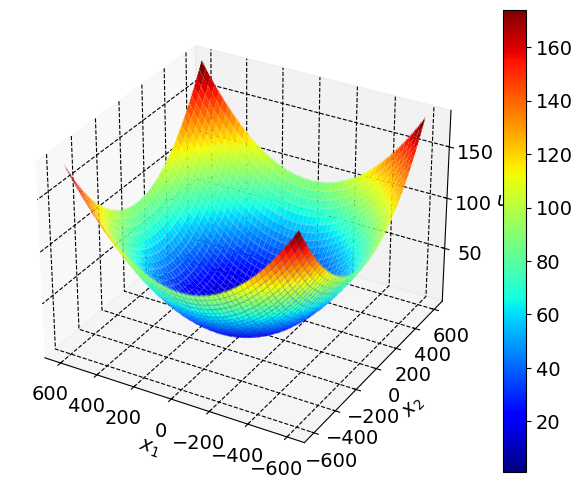

In [ ]:
def griewank(x):
    return _griewank(x[0], x[1])

def _griewank(x1, x2):
    A = x1 ** 2 / 4000 + x2 ** 2 / 4000
    B = np.cos(x1 / np.sqrt(1)) * np.cos(x2 / np.sqrt(2))
    return A - B + 1

N = 5000  # numbers in grid
lower_bound = -600  # lower bound
upper_bound = 600  # upper bound

# a. grids
x1_vec = np.linspace(lower_bound, upper_bound, N)
x2_vec = np.linspace(lower_bound, upper_bound, N)
x1_grid, x2_grid = np.meshgrid(x1_vec, x2_vec, indexing='ij')
griewank_grid = _griewank(x1_grid, x2_grid)

# b. main
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(1, 1, 1, projection='3d')
cs = ax.plot_surface(x1_grid, x2_grid, griewank_grid, cmap=cm.jet)

# c. add labels
ax.set_xlabel('$x_1$')
ax.set_ylabel('$x_2$')
ax.set_zlabel('$u$')

# d. invert xaxis
ax.invert_xaxis()

# e. add colorbar
fig.colorbar(cs);

In [ ]:
# The functtion is used to collect information while the optimizer is run
def collect(x): 
    # globals used to keep track across iterations
    global nit  # set nit = 0 before calling optimizer
    global x1s
    global x2s
    global fs

    # a. initialize list
    if nit == 0:
        x1s = [x[0]]
        x2s = [x[1]]
        fs = [griewank(x)]

    # b. append trial values
    x1s.append(x[0])
    x2s.append(x[1])
    fs.append(griewank(x))

    # c. increment number of evaluations
    nit += 1

def contour():
    global nit
    global x1s
    global x2s

    # a. contour plot
    fig = plt.figure(figsize=(10, 4))
    ax = fig.add_subplot(1, 2, 1)
    levels = [1e-6, 5 * 1e-6, 1e-5, 5 * 1e-5, 1e-4, 5 * 1e-4, 1e-3, 5 * 1e-3, 1e-2, 5 * 1e-2, 1, 2, 4, 6, 8, 12, 16, 20]
    cs = ax.contour(x1_grid, x2_grid, griewank_grid, levels=levels, cmap=cm.jet)
    fig.colorbar(cs)
    ax.plot(x1s, x2s, '-o', ms=4, color='black')
    ax.set_xlabel('$x_1$')
    ax.set_ylabel('$x_2$')

    fig.tight_layout()


def convergence(K,x0s):
    global nit
    k_grid = np.arange(K)
    x0s = np.array(x0s)

    # Create the first subplot for x0s[:,0]
    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

    # Plot x0s[:,0]
    ax[0].plot(k_grid, x0s[:, 0], '-o', ms=1, color='black')
    ax[0].set_xlabel('k-value')
    ax[0].set_ylabel('x0s[:,0]')

    # Create the second subplot for x0s[:,1]
    ax[1].plot(k_grid, x0s[:, 1], '-o', ms=1, color='black')
    ax[1].set_xlabel('k-value')
    ax[1].set_ylabel('x0s[:,1]')

    # Adjust spacing between subplots
    fig.tight_layout()

    # Display the plot
    plt.show()    

The solve_multistart() finds the global minimima of a function using refined multistart. For k up to a maximum of K starting values it draws a random uniformly distributed number in the interval from lower_bound to upper_bound.

If k is smaller than K_warm, it finds a mimima using optimize.minimize() with the 'BFGS'-method. Here the collect() function is called to count the number of evaluations. If k is larger than K_warm, the function uses a more refined method to update starting values. Here it calculates new starting values as a linear combination of the best solutions that has previously been found and the drawn uniformly distributed number. The value $\chi$ determines how close the refined set of input values is to the previus best solution, the smaller the $\chi$ the closer to the previous best solution.

The loop is broken if the set of input values yield a function value of the griewank function that is within a set tolerance of 0. The tolerance is given by "tol".

In [ ]:
# We use multistart to draw random starting values
def solve_multistart(K=1000, K_warm=10, tol=1e-8,lower_bound=-600, upper_bound=600,refined=True,print_contour=False,print_convergence=False):
    np.random.seed(2000)
    x0s = np.empty((K, 2))
    xs = np.empty((K, 2))

    fopt = np.inf
    xopt = np.nan

    # b. loop over starting points
    for k in range(K):
        # Draw random starting point
        x0s[k, :] = np.random.uniform(lower_bound, upper_bound, 2)
        # Refine starting point if k >= K_warm and refined=True
        if k >= K_warm and refined:
            # Calculate chi
            chi = 0.5 * 2 / (1 + np.exp((k - K_warm) / 100))
            # Calculate refined/effective starting point
            x0s[k, :] = chi * x0s[k, :] + (1 - chi) * xopt

        # c. optimize
        result = optimize.minimize(griewank, x0s[k, :], method='BFGS', callback=collect, tol=tol, options={'disp': False})
        xs[k, :] = result.x
        f = result.fun

        # d. update
        if f < fopt:
            fopt = f
            xopt = xs[k, :]
        
        # e. break if tolerance level is reached
        if fopt < tol:
            break
    
    # f. prints optimal input values, optimal function value and number of iterations
    print(xopt, fopt, nit)

    # g. plot
    if print_contour:
        contour()
    if print_convergence:
        convergence(K,x0s=x0s)
    # h. return results in a tuple
    return result,x0s

We run the solve_multistart function and output the resulting optimized input values, optimal function value and the number of evaluations required

[-12.56009041   8.87688873] 0.05917817705510919 9606


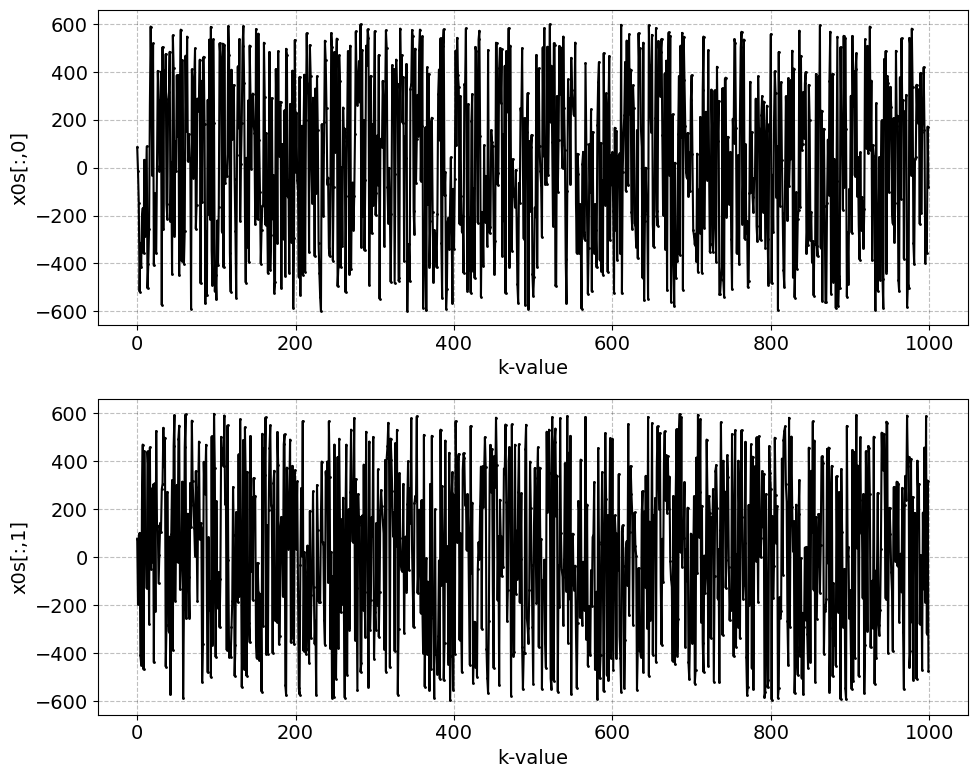

[-9.53798255e-09 -4.59010367e-09] 0.0 3282


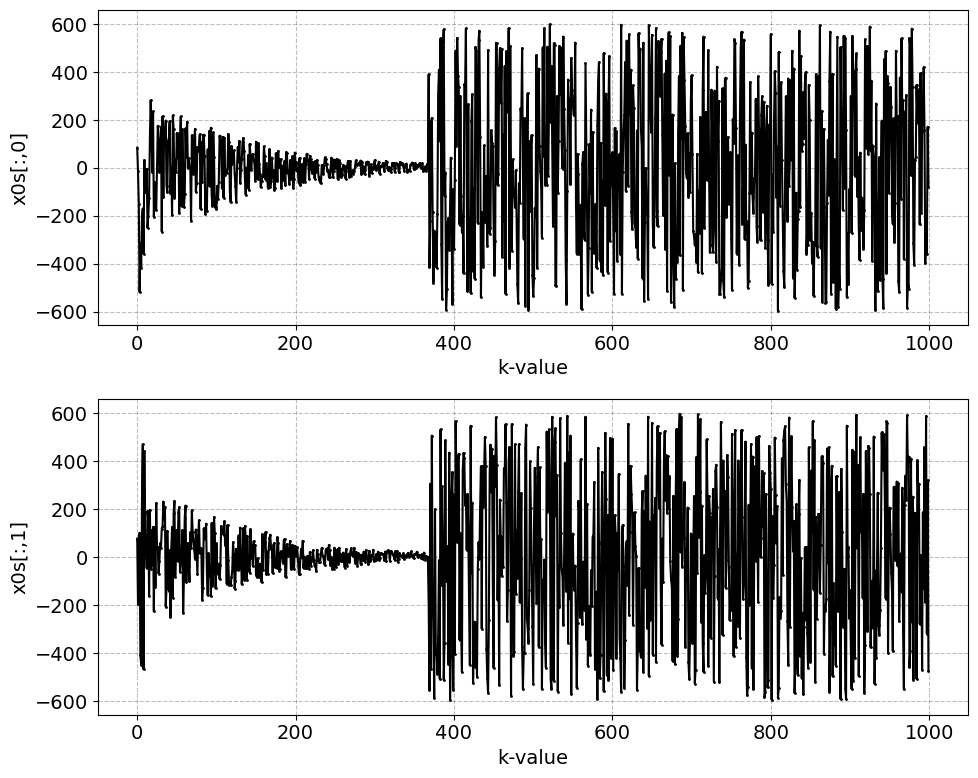

In [ ]:
nit=0
res=solve_multistart(refined=False, print_convergence=True)
nit=0
res=solve_multistart(refined=True, print_convergence=True)

**Question 2:** Is it a better idea to set $\underline{K} = 100$? Is the convergence faster?

It appears to be the case, that a $\underline{K} = 100$ results in a slower convergence (1.4 sek) in comparison to a $\underline{K} = 100$ (1.7 sek). The convergence occurs at a value around $\underline{K} = 400$ and a guess of $\underline{K} = 100$ does not speed up the process of convergence.

In [ ]:
nit=0
t0 = time.time()
res=solve_multistart(K_warm=10)
print(f'model solved in {time.time()-t0:5.1f} secs')
nit=0
t0 = time.time()
res=solve_multistart(K_warm=100)
print(f'model solved in {time.time()-t0:5.1f} secs')

[-9.53798255e-09 -4.59010367e-09] 0.0 3282
model solved in   1.4 secs
[-3.57497290e-09 -8.78489584e-09] 0.0 3817
model solved in   1.7 secs


[-3.57497290e-09 -8.78489584e-09] 0.0 3817


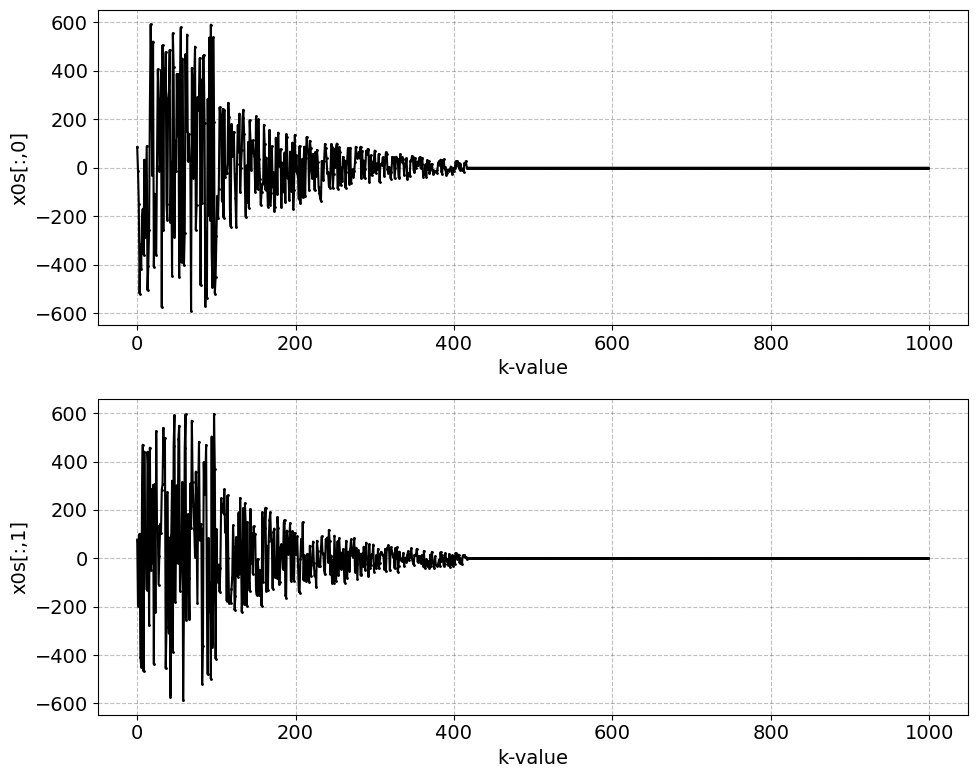

In [ ]:
nit=0
res=solve_multistart(K_warm=100, print_convergence=True)